#Green areas detection
El presente modelo, tiene como función localizar a través de filtros, las áreas verdes de múltiples imágenes, dichas imagenes, contienen terrenos irregulares, construcciones, zonas áridas, entre otras.
Base de datos recuperada de: https://www.kaggle.com/

Por: Israel Sánchez Graciano

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
 image = '/content/drive/MyDrive/images'


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


folder_path = "/content/drive/MyDrive/images"


image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]


images = []

for file in image_files:
    img_path = os.path.join(folder_path, file)
    image = cv2.imread(img_path)
    if image is not None:
        images.append((file, image))

print(f"Se cargaron {len(images)} imágenes.")


Se cargaron 124 imágenes.


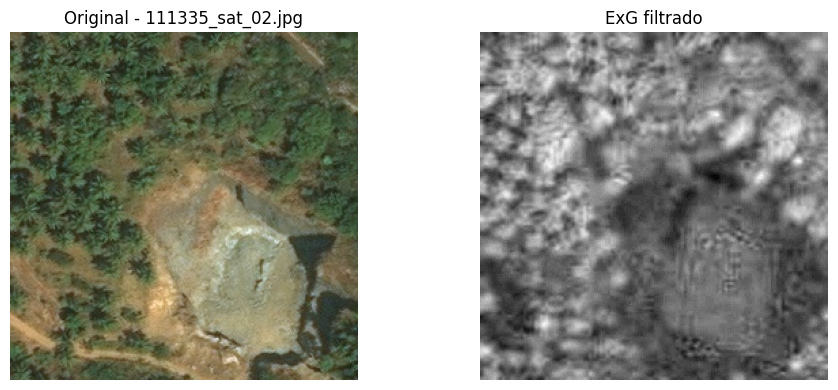

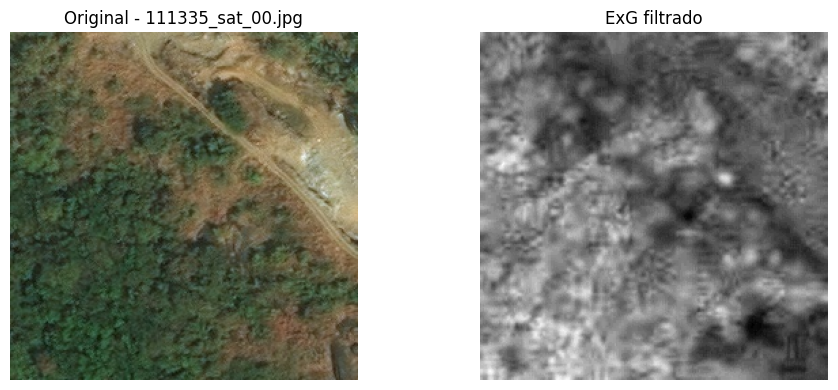

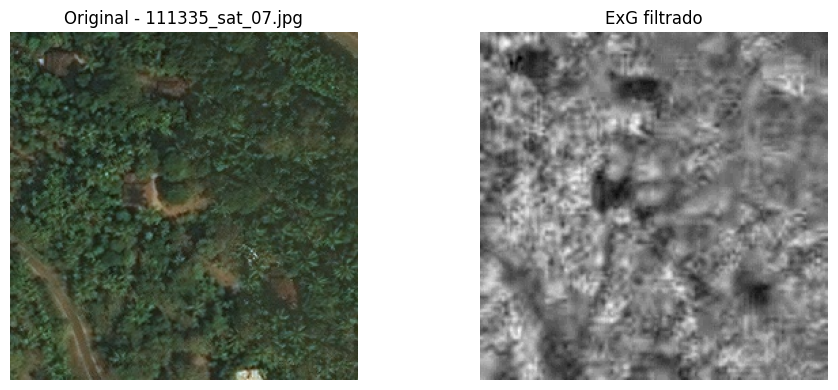

In [6]:
def apply_exg(image):
    image_float = image.astype(np.float32)
    R = image_float[:, :, 2]
    G = image_float[:, :, 1]
    B = image_float[:, :, 0]
    ExG = 2 * G - R - B
    ExG_norm = cv2.normalize(ExG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return ExG_norm.astype(np.uint8)


for i, (name, img) in enumerate(images[:3]):  # Solo los primeros 3 para no saturar
    exg_img = apply_exg(img)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - {name}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("ExG filtrado")
    plt.imshow(exg_img, cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [19]:
# Filtro ExG
def apply_exg(image):
    image = image.astype(np.float32)
    R = image[:, :, 2]
    G = image[:, :, 1]
    B = image[:, :, 0]
    ExG = 2 * G - R - B
    ExG_norm = cv2.normalize(ExG, None, 0, 255, cv2.NORM_MINMAX)
    return ExG_norm.astype(np.uint8)

# Filtro CIVE
def apply_cive(image):
    image = image.astype(np.float32)
    R = image[:, :, 2]
    G = image[:, :, 1]
    B = image[:, :, 0]
    CIVE = 0.441 * R - 0.811 * G + 0.385 * B + 18.78745
    CIVE_norm = cv2.normalize(CIVE, None, 0, 255, cv2.NORM_MINMAX)
    return CIVE_norm.astype(np.uint8)

# Filtro VARI
def apply_vari(image):
    image = image.astype(np.float32)
    R = image[:, :, 2]
    G = image[:, :, 1]
    B = image[:, :, 0]
    VARI = (G - R) / (G + R - B + 1e-6)  # evitar división por cero
    VARI_norm = cv2.normalize(VARI, None, 0, 255, cv2.NORM_MINMAX)
    return VARI_norm.astype(np.uint8)


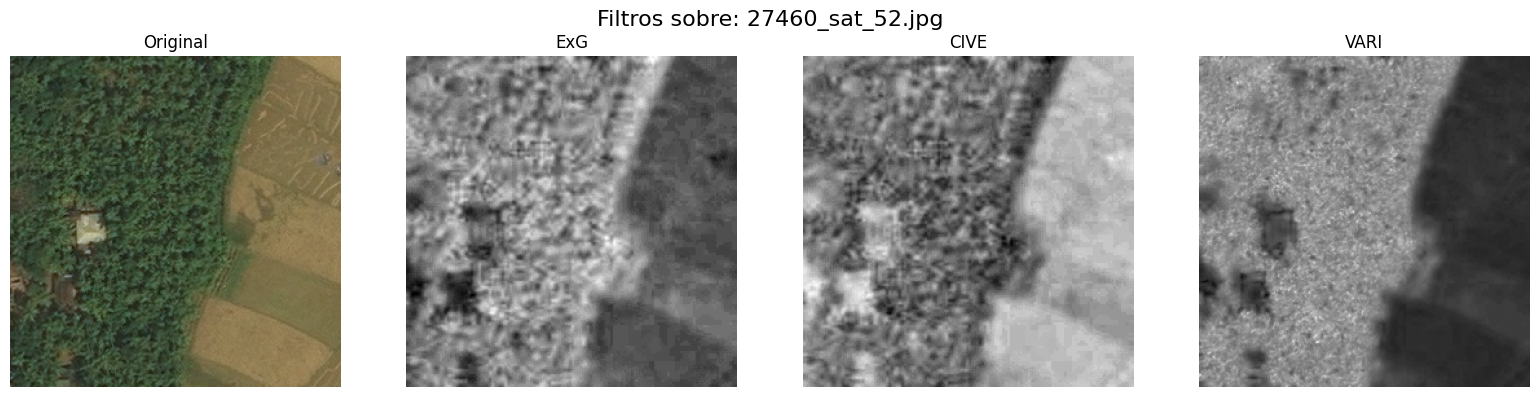

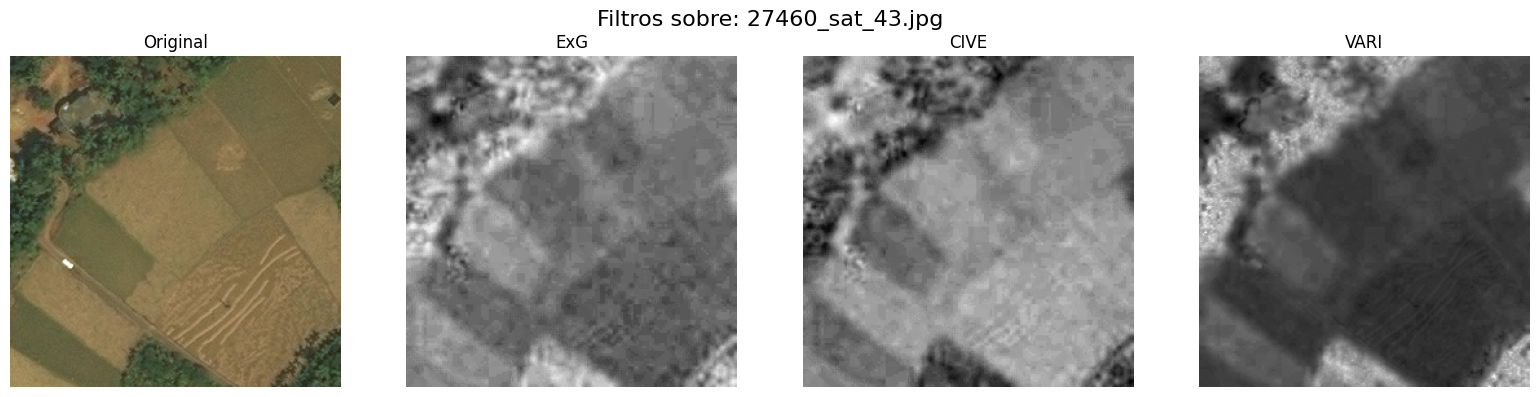

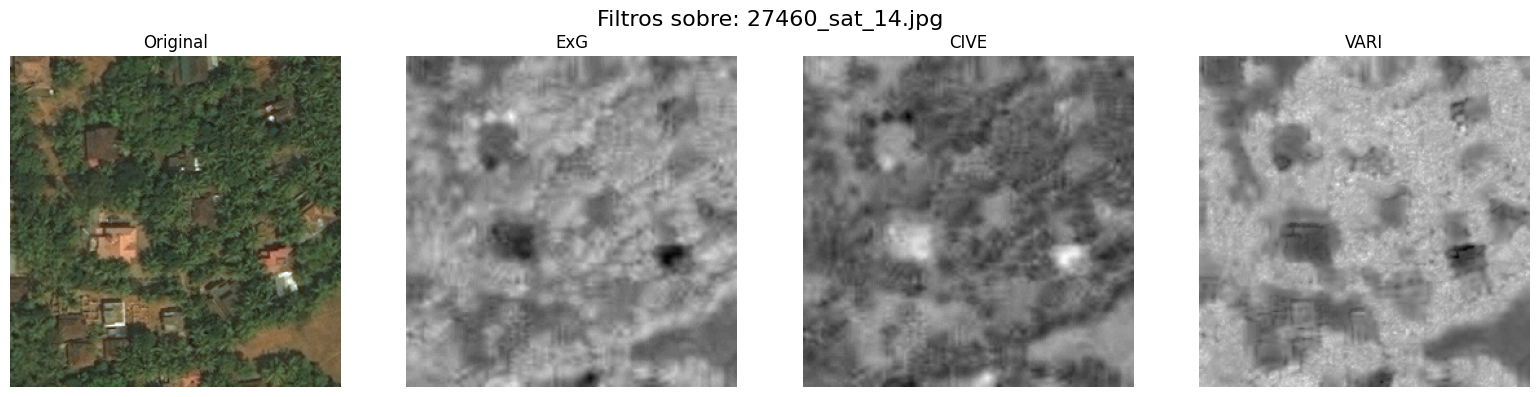

In [53]:
import matplotlib.pyplot as plt
import random

# Selecciona 3 imágenes al azar del dataset
ejemplos = random.sample(images, min(3, len(images)))

for name, img in ejemplos:
    exg_img = apply_exg(img)
    cive_img = apply_cive(img)
    vari_img = apply_vari(img)

    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Filtros sobre: {name}", fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(exg_img, cmap='gray')
    plt.title("ExG")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cive_img, cmap='gray')
    plt.title("CIVE")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(vari_img, cmap='gray')
    plt.title("VARI")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


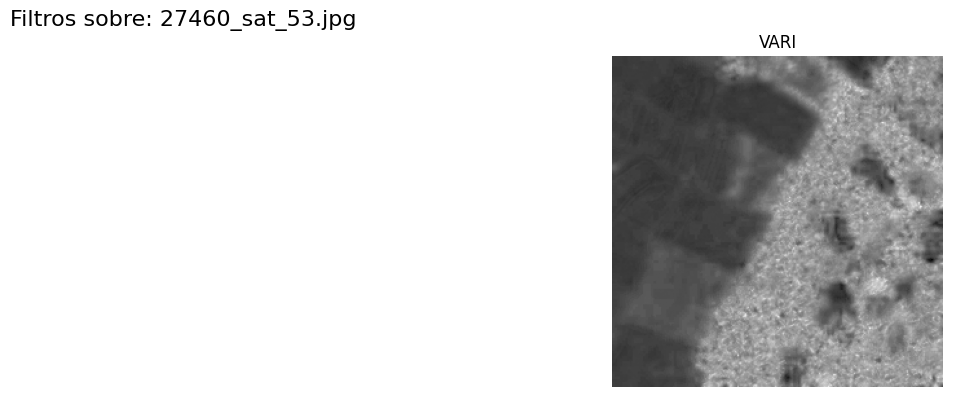

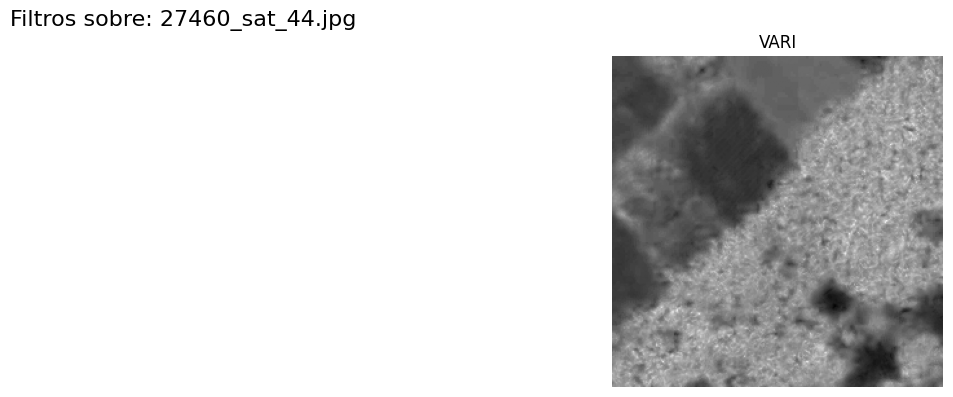

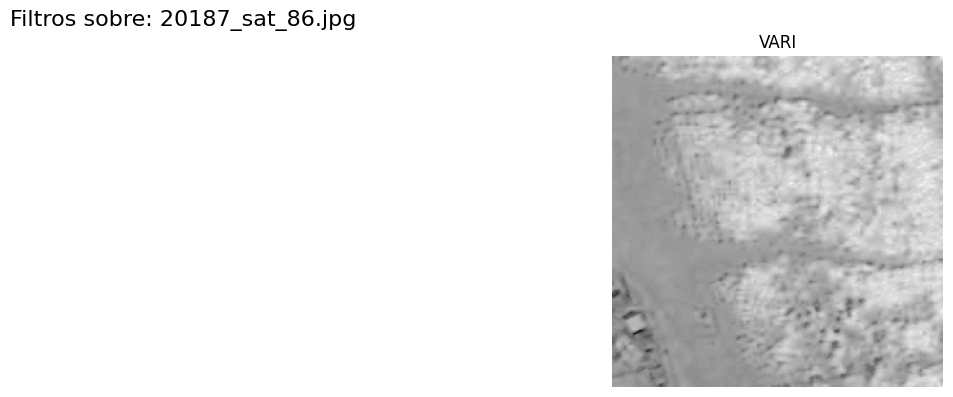

In [51]:
#Se oprtó por el filtro VARI


# Selecciona 3 imágenes al azar del dataset
ejemplos = random.sample(images, min(3, len(images)))

for name, img in ejemplos:
    vari_img = apply_vari(img)

    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Filtros sobre: {name}", fontsize=16)

    plt.subplot(1, 4, 4)
    plt.imshow(vari_img, cmap='gray')
    plt.title("VARI")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [32]:
def classify_vari(vari_img):
    """
    Classifies pixels in a VARI image as vegetation or non-vegetation.

    Args:
        vari_img: The VARI image.

    Returns:
        A binary image with 1 representing vegetation and 0 representing non-vegetation.
    """
    threshold = 100

    vegetation_mask = (vari_img > threshold).astype(np.uint8)

    return vegetation_mask

etiquetadas_vari = []

for name, img in images:
    vari_img = apply_vari(img)
    clase = classify_vari(vari_img)
    etiquetadas_vari.append((name, img, vari_img, clase))

#Entrenamiento del modelo



In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2

IMG_SIZE = 128

X = []
y = []

for _, _, vari_img, label in etiquetadas_vari:
    resized = cv2.resize(vari_img, (IMG_SIZE, IMG_SIZE))
    X.append(resized)

    y.append(1 if np.any(label) else 0)

X = np.array(X, dtype="float32")
X = np.expand_dims(X, axis=-1)
X /= 255.0

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

# Dividir dataset
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6125 - loss: 0.5818 - val_accuracy: 1.0000 - val_loss: 1.8358e-06
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 5.7163e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 1.0000 - loss: 2.4837e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 597ms/step - accuracy: 1.0000 - loss: 1.6628e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 1.0000 - loss: 1.0141e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 854ms/step - accuracy: 1.0000 - loss: 7.3001e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 1.0000 - loss: 5.6210e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 1.0000 - l

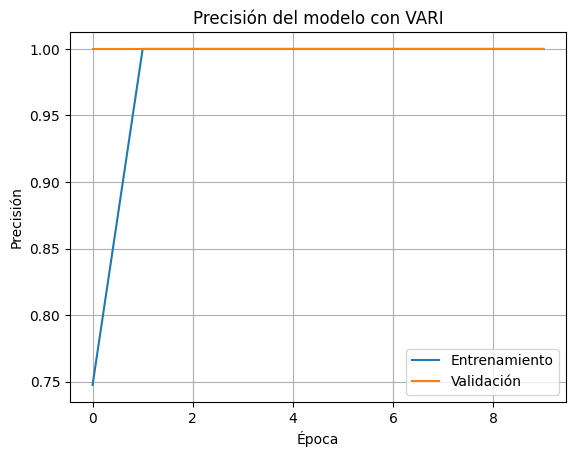

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo con VARI')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicción: 1


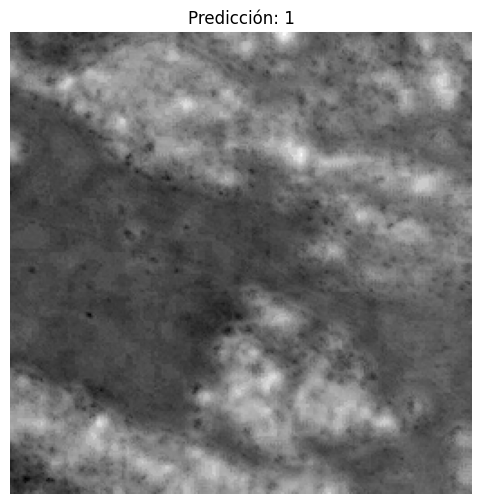

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

 #Imagen de muestra
image_path = '/content/drive/MyDrive/images/15573_sat_73.jpg'

# Cargar la imagen
new_img = cv2.imread(image_path)
if new_img is None:
    print("No se cargó la imagen ")
else:
    # Aplicar el filtro VARI
    new_vari = apply_vari(new_img)

    IMG_SIZE = 128
    new_vari_resized = cv2.resize(new_vari, (IMG_SIZE, IMG_SIZE))
    new_vari_resized = new_vari_resized.astype("float32") / 255.0


    new_input = np.expand_dims(new_vari_resized, axis=-1)
    new_input = np.expand_dims(new_input, axis=0)

    # Realizar la predicción con el modelo
    pred = model.predict(new_input)
    predicted_class = np.argmax(pred, axis=1)[0]

    # Convertir el valor codificado a la etiqueta original
    class_label = label_encoder.inverse_transform([predicted_class])[0]
    print("Predicción:", class_label)

    # Mostrar la imagen filtrada con la etiqueta predicha
    plt.figure(figsize=(6, 6))
    plt.imshow(new_vari, cmap='gray')
    plt.title(f"Predicción: {class_label}")
    plt.axis("off")
    plt.show()


#Conclusión
Para el desarrollo de este modelo de clasificación de imágenes satelitales con enfoque en la identificación de áreas verdes, se evaluaron diversos filtros diseñados para resaltar la vegetación. Entre ellos, se consideraron el ExG (Excess Green), CIVE (Color Index of Vegetation Extraction) y VARI (Visible Atmospherically Resistant Index).Tras aplicar y comparar estos filtros sobre muestras de la base de datos, se optó por el uso del filtro VARI por las siguientes razones:


*   No requiere banda infrarroja
*   Mayor rubustez ante variaciones atmosféricas y de iluminación
*   Mejor rendimiento visual y cuantitativo


Por lo tanto, gracias al uso del filtro VARI, fue posible construir un modelo de aprendizaje profundo capaz de clasificar imágenes en tres niveles de vegetación, con una buena precisión, usando únicamente información visual estándar.






